In [1]:
import tensorflow as tf # 2.3
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.datasets.mnist as mnist

Import les donées

In [2]:
(train_image, train_labels), (test_image, test_labels) = tf.keras.datasets.mnist.load_data()
# train_image.shape = (60000, 28, 28), train_labels.shape = (60000,)

Traitement les données

In [3]:
# Normalisation les données 0 - 255 en -1 - 1
train_image = (train_image - 127.5)/127.5
test_image = (test_image - 127.5)/127.5 
# Transformation de type 
train_image = tf.cast(train_image, tf.float32)
test_image = tf.cast(test_image, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

Créer un jeu de données 

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(60000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

Construire le modèle MLP et l'entraîner 

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax') #kernel_regularizer
])

In [6]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
history = model.fit(dataset,validation_data=test_dataset,epochs=10)

Epoch 1/10
235/235 [==============================] - 5s 17ms/step - loss: 0.4664 - acc: 0.8578 - val_loss: 0.2434 - val_acc: 0.9250
Epoch 2/10
235/235 [==============================] - 4s 15ms/step - loss: 0.2083 - acc: 0.9378 - val_loss: 0.1901 - val_acc: 0.9403
Epoch 3/10
235/235 [==============================] - 4s 15ms/step - loss: 0.1566 - acc: 0.9529 - val_loss: 0.1481 - val_acc: 0.9556
Epoch 4/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1239 - acc: 0.9628 - val_loss: 0.1304 - val_acc: 0.9575
Epoch 5/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1080 - acc: 0.9673 - val_loss: 0.1086 - val_acc: 0.9664
Epoch 6/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0906 - acc: 0.9728 - val_loss: 0.0991 - val_acc: 0.9676
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0782 - acc: 0.9754 - val_loss: 0.1046 - val_acc: 0.9678
Epoch 8/10
235/235 [==============================] - 2s 9ms/step - lo

In [7]:
model_L1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax',name='dense3',kernel_regularizer=tf.keras.regularizers.L1(-0.3)) #kernel_regularizer
])

In [8]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model_L1.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
history_L1 = model_L1.fit(dataset,validation_data=test_dataset,epochs=10) 


Epoch 1/10
235/235 [==============================] - 3s 9ms/step - loss: -49.9240 - acc: 0.8666 - val_loss: -72.6662 - val_acc: 0.9286
Epoch 2/10
235/235 [==============================] - 2s 9ms/step - loss: -94.9992 - acc: 0.9386 - val_loss: -117.6471 - val_acc: 0.9477
Epoch 3/10
235/235 [==============================] - 2s 9ms/step - loss: -140.0087 - acc: 0.9527 - val_loss: -162.6673 - val_acc: 0.9520
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: -185.0429 - acc: 0.9564 - val_loss: -207.7014 - val_acc: 0.9523
Epoch 5/10
235/235 [==============================] - 2s 9ms/step - loss: -230.1098 - acc: 0.9614 - val_loss: -252.7666 - val_acc: 0.9530
Epoch 6/10
235/235 [==============================] - 2s 9ms/step - loss: -275.1841 - acc: 0.9635 - val_loss: -297.8398 - val_acc: 0.9576
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: -320.2791 - acc: 0.9670 - val_loss: -342.9275 - val_acc: 0.9600
Epoch 8/10
235/235 [=================

Implémenter FGSM(Fast Gradient Sign Method)
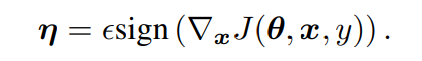

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  return signed_grad

In [10]:
perturbations = create_adversarial_pattern(test_image, test_labels)

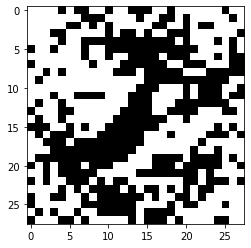

In [11]:
#check la première perturbation 查看第一个扰动
plt.imshow(perturbations[0],cmap='gray_r')#image en niveaux de gris

Définir une fonction pour plot les images

In [12]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette prédite par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, adv_label_L1, num = 10):
  fig = plt.figure(figsize=(2*num,3)) # figsize:指定figure的宽和高，单位为英寸
  for i in range(num):   # pre_image的shape的第一个维度就是个数，这里是num
      plt.subplot(1,num,i+1) # 几行几列的 第i+1个图片（从1开始）
      plt.imshow(image[i,:,:],cmap='gray') # + 1)/2) # 加1除2: 将生成的-1～1的图片弄到0-1之间,
      plt.title('{} -> {} -> {}'.format(label[i],adv_label[i],adv_label_L1[i]))
      plt.axis('off') # 不要坐标
  plt.show()


Ajouter la perturbations et Tester dans le jeu de test

epsilons = 0:
313/313 [==============================] - 1s 2ms/step


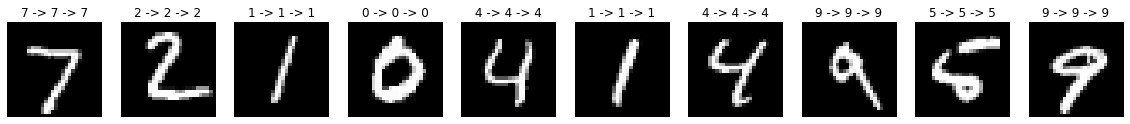

epsilons = 0.05:
313/313 [==============================] - 1s 2ms/step


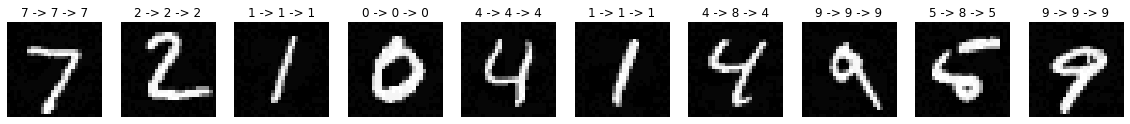

epsilons = 0.1:
313/313 [==============================] - 0s 2ms/step


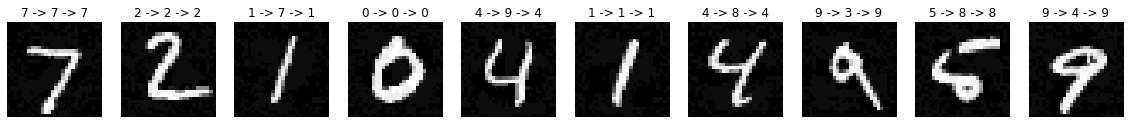

epsilons = 0.15:
313/313 [==============================] - 0s 1ms/step


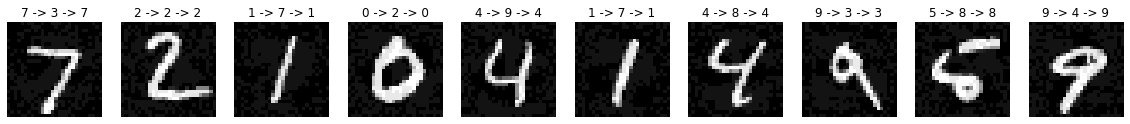

epsilons = 0.2:
313/313 [==============================] - 0s 1ms/step


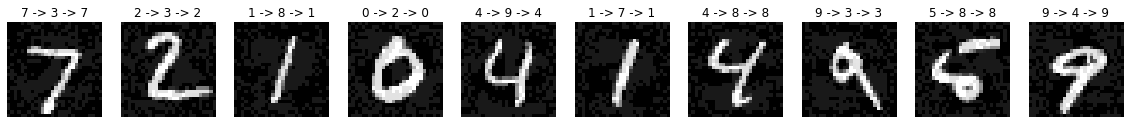

epsilons = 0.25:
313/313 [==============================] - 1s 2ms/step


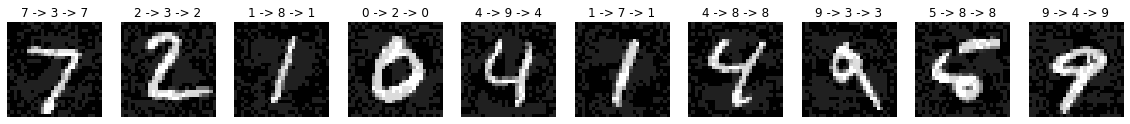

epsilons = 0.3:
313/313 [==============================] - 1s 2ms/step


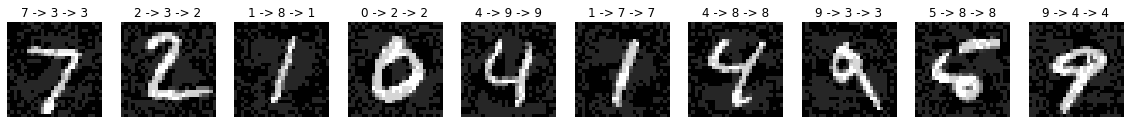

In [13]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
adv_acc_list_L1 = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 获取原始图片的预测结果
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model.predict(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])

  adv_predict_label_L1 = model_L1.predict(adv_image)
  adv_predict_label_L1 = np.array([np.argmax(i) for i in adv_predict_label_L1])

  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score = model.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])

  score_L1 = model_L1.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list_L1.append(score_L1[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, adv_predict_label_L1, 10)

# labels: model sur image originales  -> model sur adversarial exemples    -> model_L1 sur adversarial exemples

Afficher la précision en fonction d'epsilons

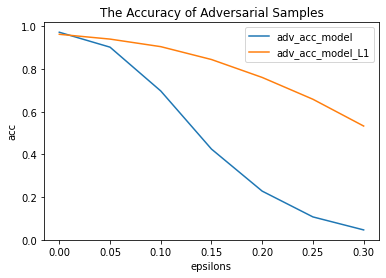

adv_acc_model [0.9722999930381775, 0.902400016784668, 0.6972000002861023, 0.42489999532699585, 0.22779999673366547, 0.10700000077486038, 0.04610000178217888]
adv_acc_model_L1 [0.9627000093460083, 0.9401999711990356, 0.9047999978065491, 0.8445000052452087, 0.7605000138282776, 0.65829998254776, 0.532800018787384]


In [14]:
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.plot(epsilons,adv_acc_list,label='adv_acc_model')
plt.plot(epsilons,adv_acc_list_L1,label='adv_acc_model_L1')
plt.legend()
plt.show()
print('adv_acc_model',adv_acc_list)
print('adv_acc_model_L1',adv_acc_list_L1)